In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Directory and file paths
train_dir = 'train_set/images'
val_dir = 'val_set/images'
train_ann_file = 'train_annotation.csv'
val_ann_file = 'val_annotation.csv'

# Parameters
input_shape = (224, 224, 3)  # Specify input image shape
batch_size = 24
num_emotions = 8

# Function to one-hot encode emotion labels
def one_hot_encode(number, num_classes=num_emotions):
    one_hot_vector = np.zeros(num_classes)
    one_hot_vector[number] = 1
    return one_hot_vector

# Training parameters
# epoch_steps = 30000 // batch_size
epoch_steps=30
val_steps = 30
epoch = 10


In [2]:
# from numba import cuda

# device = cuda.get_current_device()
# device.reset()


In [3]:
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D
from tensorflow.keras import Model

In [4]:
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [5]:
# Define CCC function
def ccc(y_true, y_pred):
    y_true_mean = tf.reduce_mean(y_true, axis=0)
    y_pred_mean = tf.reduce_mean(y_pred, axis=0)
    
    covariance = tf.reduce_mean((y_true - y_true_mean) * (y_pred - y_pred_mean))
    true_var = tf.reduce_mean((y_true - y_true_mean) ** 2)
    pred_var = tf.reduce_mean((y_pred - y_pred_mean) ** 2)
    
    ccc_value = 2 * covariance / (true_var + pred_var + tf.square(y_true_mean - y_pred_mean))
    
    return 1 - ccc_value

In [6]:
# Function to generate augmented data for minority class images
def data_generator(dir_path, ann_file, batch_size, input_shape, augment=False):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    minority_classes=[4,5,7]
    anno = pd.read_csv(ann_file)
    while True:
        batch_paths = np.random.choice(anno['filename'], size=batch_size)
        batch_input, batch_output_valence, batch_output_arousal, batch_output_emotion = [], [], [], []

        for input_path in batch_paths:
            img_path = os.path.join(dir_path, str(input_path)+'.jpg')
            img = load_img(img_path, target_size=input_shape)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Reshape to add batch dimension
            img_array = next(datagen.flow(img_array, batch_size=1))[0]
            row = anno[anno["filename"] == input_path]
            if row.empty:
                print(f"Warning: No annotation found for {input_path}")
                continue
            
            batch_input.append(img_array)
            batch_output_valence.append(row["Valance"].values[0])
            batch_output_arousal.append(row["Arousal"].values[0])
            batch_output_emotion.append(one_hot_encode(row["Expression"].values[0]))

        batch_input = np.array(batch_input)
        batch_output_valence = np.array(batch_output_valence)
        batch_output_arousal = np.array(batch_output_arousal)
        batch_output_emotion = np.array(batch_output_emotion)

        yield batch_input, {"valence": batch_output_valence, "arousal": batch_output_arousal, "emotion": batch_output_emotion}

In [7]:
#Downsampling majority class and upsampling minority class
def data_generator_down_up(dir_path, ann_file, batch_size, input_shape, augment=False):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    minority_classes = [4, 5, 7]
    ann_file = pd.read_csv(ann_file)
    majority_classes = ann_file[~ann_file["Expression"].isin(minority_classes)]
    minority_classes = ann_file[ann_file["Expression"].isin(minority_classes)]

    while True:
        batch_input, batch_output_valence, batch_output_arousal, batch_output_emotion = [], [], [], []

        majority_batch_paths = np.random.choice(majority_classes['filename'], size=batch_size // 2)
        minority_batch_paths = np.random.choice(minority_classes['filename'], size=batch_size // 2)
        # Determine the number of samples to take from minority and majority classes
        # minority_size = int(batch_size * 0.50)
        # majority_size = batch_size - minority_size
        
        # # Randomly select samples from the minority and majority annotations
        # minority_batch_paths = minority_classes.sample(n=minority_size, replace=True)['filename']
        # majority_batch_paths = majority_classes.sample(n=majority_size, replace=True)['filename']
        
        for input_path in np.concatenate((majority_batch_paths, minority_batch_paths)):
            img_path = os.path.join(dir_path, str(input_path)+'.jpg')
            img = load_img(img_path, target_size=input_shape)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Reshape to add batch dimension
            
            row = ann_file[ann_file["filename"] == input_path]
            if row.empty:
                print(f"Warning: No annotation found for {input_path}")
                continue
            
            # Check if the image belongs to a minority class
            emotion_class = row["Expression"].values[0]
            if augment and emotion_class in minority_classes:
                # Apply data augmentation
                for _ in range(3):  # Generate 3 augmented images
                    augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
                    batch_input.append(augmented_img)  # Remove batch dimension
                    batch_output_valence.append(row["Valance"].values[0])
                    batch_output_arousal.append(row["Arousal"].values[0])
                    batch_output_emotion.append(one_hot_encode(row["Expression"].values[0]))
                    
            else:
                # No augmentation for majority classes
                batch_input.append(img_array[0])
                batch_output_valence.append(row["Valance"].values[0])
                batch_output_arousal.append(row["Arousal"].values[0])
                batch_output_emotion.append(one_hot_encode(row["Expression"].values[0]))

        batch_input = np.array(batch_input)
        batch_output_valence = np.array(batch_output_valence)
        batch_output_arousal = np.array(batch_output_arousal)
        batch_output_emotion = np.array(batch_output_emotion)

        yield batch_input, {"valence": batch_output_valence, "arousal": batch_output_arousal, "emotion": batch_output_emotion}

In [8]:
# Define the data generator function with augmentation and equal class distribution
def data_generator_equal(dir_path, ann_file, batch_size, input_shape, augment=False, num_classes=8, augment_count=1):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    anno = pd.read_csv(ann_file)
    class_counts = anno['Expression'].value_counts().to_dict()

    while True:
        # Initialize empty lists for the batch
        batch_input, batch_output_valence, batch_output_arousal, batch_output_emotion = [], [], [], []
        
        # Determine the number of samples per class
        samples_per_class = batch_size // num_classes
        
        for emotion_class in range(num_classes):
            class_anno = anno[anno["Expression"] == emotion_class]
            selected_paths = class_anno.sample(n=samples_per_class, replace=True)['filename']
            
            for input_path in selected_paths:
                img_path = os.path.join(dir_path, str(input_path)+'.jpg')
                try:
                    img = load_img(img_path, target_size=input_shape)
                    img_array = img_to_array(img)
                    img_array = np.expand_dims(img_array, axis=0)  # Reshape to add batch dimension
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue
                
                row = class_anno[class_anno["filename"] == input_path]
                if row.empty:
                    print(f"Warning: No annotation found for {input_path}")
                    continue
                
                # Check if the image should be augmented
                if augment:
                    # Apply data augmentation
                    for _ in range(augment_count):  # Generate augment_count augmented images
                        augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
                        batch_input.append(augmented_img)  # Remove batch dimension
                        batch_output_valence.append(row["Valance"].values[0])
                        batch_output_arousal.append(row["Arousal"].values[0])
                        batch_output_emotion.append(one_hot_encode(row["Expression"].values[0], num_classes=num_classes))
                else:
                    # No augmentation
                    batch_input.append(img_array[0])
                    batch_output_valence.append(row["Valance"].values[0])
                    batch_output_arousal.append(row["Arousal"].values[0])
                    batch_output_emotion.append(one_hot_encode(row["Expression"].values[0], num_classes=num_classes))

        # Convert lists to numpy arrays
        try:
            batch_input = np.array(batch_input)
            batch_output_valence = np.array(batch_output_valence)
            batch_output_arousal = np.array(batch_output_arousal)
            batch_output_emotion = np.array(batch_output_emotion)
        except Exception as e:
            print(f"Error converting batch to numpy arrays: {e}")
            continue
        yield batch_input, {"valence": batch_output_valence, "arousal": batch_output_arousal, "emotion": batch_output_emotion}

Model Definitioin: AlexNet

In [9]:

# MobileNet block
def mobilnet_block (x, filters, strides):
    
    x = DepthwiseConv2D(kernel_size = 3, strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters = filters, kernel_size = 1, strides = 1)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x
#stem of the model
input_layer = Input(shape = (224,224,3))
x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
# main part of the model
x = mobilnet_block(x, filters = 64, strides = 1)
x = mobilnet_block(x, filters = 128, strides = 2)
x = mobilnet_block(x, filters = 128, strides = 1)
x = mobilnet_block(x, filters = 256, strides = 2)
x = mobilnet_block(x, filters = 256, strides = 1)
x = mobilnet_block(x, filters = 512, strides = 2)
for _ in range (5):
     x = mobilnet_block(x, filters = 512, strides = 1)
x = mobilnet_block(x, filters = 1024, strides = 2)
x = mobilnet_block(x, filters = 1024, strides = 1)
x = AvgPool2D (pool_size = 7, strides = 1, data_format='channels_first')(x)


x = Flatten()(x)
x = Dense(1000, activation='relu')(x)


# Define task-specific layers for valence
dense_valence = Dense(64, activation='relu')(x)
output_valence = Dense(1, activation='sigmoid', name='valence')(dense_valence)

# Define task-specific layers for arousal
dense_arousal = Dense(64, activation='relu')(x)
output_arousal = Dense(1, activation='sigmoid', name='arousal')(dense_arousal)

# Define task-specific layers for emotion
dense_emotion = Dense(64, activation='relu')(x)
output_emotion = Dense(num_emotions, activation='softmax', name='emotion')(dense_emotion)

In [10]:
# Compile the model
modelOri = Model(inputs=input_layer, outputs=[output_valence, output_arousal, output_emotion])
modelOri.compile(optimizer=Adam(),
              loss={'valence': 'mse', 'arousal': 'mse', 'emotion': 'categorical_crossentropy'},
              metrics={'valence': ['mae','accuracy',ccc,rmse], 'arousal': ['mae','accuracy', ccc, rmse], 'emotion': ['accuracy']})
# input_shape = [224, 224]
# Training and validation data generators
train_genOri = data_generator(train_dir, train_ann_file, batch_size, input_shape)
val_genOri = data_generator(val_dir, val_ann_file, batch_size, input_shape)

# Callbacks
callbacks = [
    EarlyStopping(monitor='valence_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_modelOri.h5', save_best_only=True, monitor='valence_loss'),
    ReduceLROnPlateau(monitor='valence_loss', factor=0.2, patience=5, min_lr=1e-6)
]

# Train the model
historyOri = modelOri.fit(train_genOri, steps_per_epoch=epoch_steps, epochs=epoch, callbacks=callbacks)

Epoch 1/10
30/30 [==============================] - 20s 456ms/step - loss: 2.5157 - valence_loss: 0.3304 - arousal_loss: 0.1179 - emotion_loss: 2.0674 - valence_mae: 0.4908 - valence_accuracy: 0.0153 - valence_ccc: 1.0002 - valence_rmse: 0.5710 - arousal_mae: 0.2429 - arousal_accuracy: 0.0278 - arousal_ccc: 0.9953 - arousal_rmse: 0.3326 - emotion_accuracy: 0.4056
Epoch 2/10
30/30 [==============================] - 14s 467ms/step - loss: 1.9904 - valence_loss: 0.3157 - arousal_loss: 0.1007 - emotion_loss: 1.5740 - valence_mae: 0.4799 - valence_accuracy: 0.0125 - valence_ccc: 1.0000 - valence_rmse: 0.5589 - arousal_mae: 0.2235 - arousal_accuracy: 0.0292 - arousal_ccc: 1.0000 - arousal_rmse: 0.3078 - emotion_accuracy: 0.4611
Epoch 3/10
30/30 [==============================] - 14s 468ms/step - loss: 2.0506 - valence_loss: 0.3022 - arousal_loss: 0.1121 - emotion_loss: 1.6362 - valence_mae: 0.4678 - valence_accuracy: 0.0167 - valence_ccc: 1.0000 - valence_rmse: 0.5470 - arousal_mae: 0.2422 -

In [11]:
with open('plots/MobileNethistoryOri.pkl', 'wb') as file:
    pickle.dump(historyOri.history, file)

In [12]:
# Collect true labels and predictions
y_true_valence, y_pred_valence = [], []
y_true_arousal, y_pred_arousal = [], []
y_true_emotion, y_pred_emotion = [], []

resultallOri = modelOri.evaluate(val_genOri, steps=val_steps)

30/30 [==============================] - 11s 345ms/step - loss: 3.9586 - valence_loss: 0.2632 - arousal_loss: 0.2650 - emotion_loss: 3.4304 - valence_mae: 0.4242 - valence_accuracy: 0.0181 - valence_ccc: 1.0000 - valence_rmse: 0.5108 - arousal_mae: 0.4309 - arousal_accuracy: 0.0292 - arousal_ccc: 1.0000 - arousal_rmse: 0.5128 - emotion_accuracy: 0.1306


In [13]:
# Convert the results to a DataFrame

df_results = pd.DataFrame([resultallOri], columns=modelOri.metrics_names)

# Save the DataFrame to a CSV file
df_results.to_csv("plots/csv_files_results/MobileNetOri_results.csv", index=False)

In [14]:
for _ in range(val_steps):
    x_val, y_val = next(val_genOri)
    y_pred = modelOri.predict(x_val)
    
    y_true_valence.extend(y_val['valence'])
    y_pred_valence.extend(y_pred[0].squeeze())  # Squeeze to match shape
    y_true_arousal.extend(y_val['arousal'])
    y_pred_arousal.extend(y_pred[1].squeeze())  # Squeeze to match shape
    y_true_emotion.extend(y_val['emotion'])
    y_pred_emotion.extend(y_pred[2])

# Convert lists to arrays
y_true_valence = np.array(y_true_valence)
y_pred_valence = np.array(y_pred_valence)
y_true_arousal = np.array(y_true_arousal)
y_pred_arousal = np.array(y_pred_arousal)
y_true_emotion = np.argmax(np.array(y_true_emotion), axis=1)
y_pred_emotion = np.argmax(np.array(y_pred_emotion), axis=1)

# Calculate Precision, Recall, and F1-Score for emotion
true_positives = np.sum((y_pred_emotion == y_true_emotion) & (y_true_emotion == 1))
predicted_positives = np.sum(y_pred_emotion == 1)
actual_positives = np.sum(y_true_emotion == 1)

precision = true_positives / predicted_positives if predicted_positives > 0 else 0
recall = true_positives / actual_positives if actual_positives > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
evaluation_metrics = {
    "Emotion precision": round(precision, 4),
    "Emotion recall": round(recall, 4),
    "Emotion F1-Score": round(f1_score, 4),
}

df_results = pd.DataFrame([evaluation_metrics])

# Save the DataFrame to a CSV file
df_results.to_csv("plots/csv_files_results/PRF_emotion_MobileNetOri.csv", index=False)


Precision: 0.1278
Recall: 1.0000
F1-Score: 0.2266


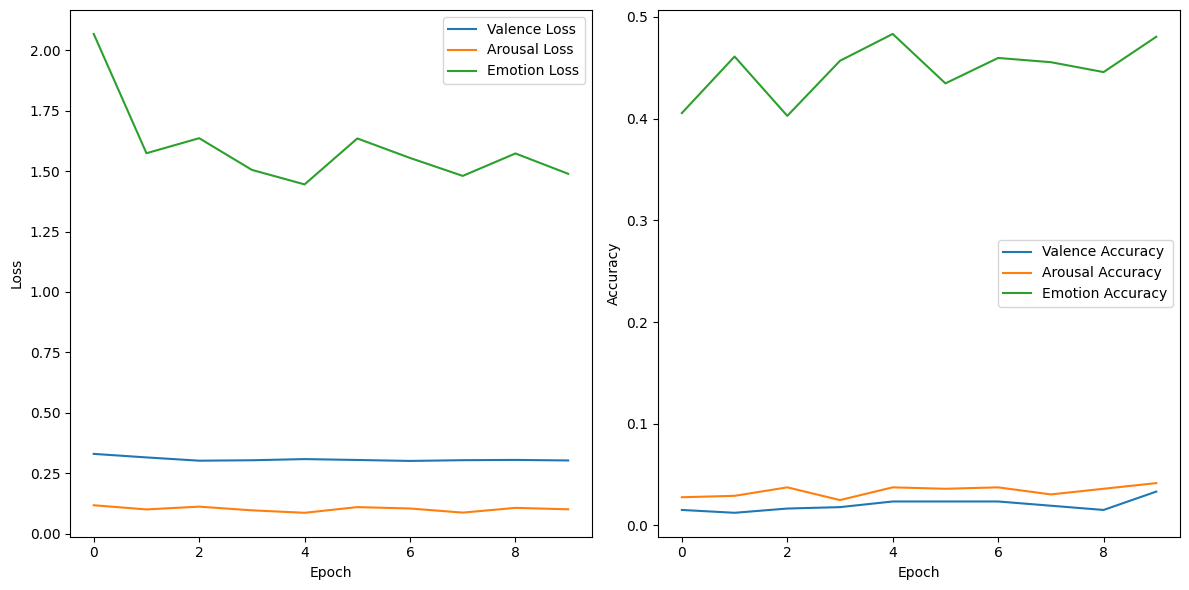

In [15]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(historyOri.history['valence_loss'], label='Valence Loss')
plt.plot(historyOri.history['arousal_loss'], label='Arousal Loss')
plt.plot(historyOri.history['emotion_loss'], label='Emotion Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(historyOri.history['valence_accuracy'], label='Valence Accuracy')
plt.plot(historyOri.history['arousal_accuracy'], label='Arousal Accuracy')
plt.plot(historyOri.history['emotion_accuracy'], label='Emotion Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("plots/MobileNetOritrainingloss_acc.pdf",bbox_inches='tight')
plt.show()

In [16]:
# modelCW = Model(inputs=input_layer, outputs=[output_valence, output_arousal, output_emotion])
# # Calculate class weights
# total_samples = 134415 + 74874 + 25459 + 24882 + 14090 + 6378 + 3803 + 3750
# class_weights = {
#     "valence": 1.0,
#     "arousal": 1.0,
#     "emotion": {
#         0: total_samples / 134415,  # Happy
#         1: total_samples / 74874,   # Neutral
#         2: total_samples / 25459,   # Sad
#         3: total_samples / 24882,   # Anger
#         4: total_samples / 14090,   # Surprise
#         5: total_samples / 6378,    # Fear
#         6: total_samples / 3803,    # Disgust
#         7: total_samples / 3750     # Contempt
#     }
# }

# modelCW.compile(optimizer=Adam(),
#               loss={'valence': 'mse', 'arousal': 'mse', 'emotion': 'categorical_crossentropy'},
#               metrics={'valence': ['mae','accuracy',ccc, rmse], 'arousal': ['mae','accuracy', ccc, rmse], 'emotion': ['accuracy']},
#               loss_weights=class_weights)  # Pass class weights to the loss_weights parameter

# # Training and validation data generators
# train_genCW = data_generator(train_dir, train_ann_file, batch_size, input_shape)
# val_genCW = data_generator(val_dir, val_ann_file, batch_size, input_shape)


# # Callbacks
# callbacks = [
#     EarlyStopping(monitor='valence_loss', patience=10, restore_best_weights=True),
#     ModelCheckpoint('best_modelAlexNetWC.h5', save_best_only=True, monitor='valence_loss'),
#     ReduceLROnPlateau(monitor='valence_loss', factor=0.2, patience=5, min_lr=1e-6)
# ]

# # Train the model
# historyCW = modelCW.fit(train_genCW, steps_per_epoch=epoch_steps, epochs=epoch, callbacks=callbacks)

In [17]:
# with open('plots/MobileNethistoryCW.pkl', 'wb') as file:
#     pickle.dump(historyCW.history, file)

In [18]:
# # Collect true labels and predictions
# y_true_valence, y_pred_valence = [], []
# y_true_arousal, y_pred_arousal = [], []
# y_true_emotion, y_pred_emotion = [], []

# resultallCW = modelCW.evaluate(val_genCW, steps=val_steps)

In [19]:
# # Convert the results to a DataFrame
# df_results = pd.DataFrame([resultallCW], columns=modelCW.metrics_names)

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/csv_files_results/MobileNetCW_results.csv", index=False)

In [20]:
# for _ in range(val_steps):
#     x_val, y_val = next(val_genCW)
#     y_pred = modelCW.predict(x_val)
    
#     y_true_valence.extend(y_val['valence'])
#     y_pred_valence.extend(y_pred[0].squeeze())  # Squeeze to match shape
#     y_true_arousal.extend(y_val['arousal'])
#     y_pred_arousal.extend(y_pred[1].squeeze())  # Squeeze to match shape
#     y_true_emotion.extend(y_val['emotion'])
#     y_pred_emotion.extend(y_pred[2])

# # Convert lists to arrays
# y_true_valence = np.array(y_true_valence)
# y_pred_valence = np.array(y_pred_valence)
# y_true_arousal = np.array(y_true_arousal)
# y_pred_arousal = np.array(y_pred_arousal)
# y_true_emotion = np.argmax(np.array(y_true_emotion), axis=1)
# y_pred_emotion = np.argmax(np.array(y_pred_emotion), axis=1)

# # Calculate Precision, Recall, and F1-Score for emotion
# true_positives = np.sum((y_pred_emotion == y_true_emotion) & (y_true_emotion == 1))
# predicted_positives = np.sum(y_pred_emotion == 1)
# actual_positives = np.sum(y_true_emotion == 1)

# precision = true_positives / predicted_positives if predicted_positives > 0 else 0
# recall = true_positives / actual_positives if actual_positives > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)


# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1_score:.4f}")
# evaluation_metrics = {
#     "Emotion precision": round(precision, 4),
#     "Emotion recall": round(recall, 4),
#     "Emotion F1-Score": round(f1_score, 4),
# }

# df_results = pd.DataFrame([evaluation_metrics])

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/csv_files_results/PRF_emotion_MobileNetCW.csv", index=False)


In [21]:
# # Plot training and validation loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(historyCW.history['valence_loss'], label='Valence Loss')
# plt.plot(historyCW.history['arousal_loss'], label='Arousal Loss')
# plt.plot(historyCW.history['emotion_loss'], label='Emotion Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plot training and validation accuracy
# plt.subplot(1, 2, 2)
# plt.plot(historyCW.history['valence_accuracy'], label='Valence Accuracy')
# plt.plot(historyCW.history['arousal_accuracy'], label='Arousal Accuracy')
# plt.plot(historyCW.history['emotion_accuracy'], label='Emotion Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig("plots/MobileNetCWtrainingloss_acc.pdf",bbox_inches='tight')
# plt.show()

In [22]:
# # Compile the model
# modelUD = Model(inputs=input_layer, outputs=[output_valence, output_arousal, output_emotion])
# modelUD.compile(optimizer=Adam(),
#               loss={'valence': 'mse', 'arousal': 'mse', 'emotion': 'categorical_crossentropy'},
#               metrics={'valence': ['mae','accuracy',ccc, rmse], 'arousal': ['mae','accuracy', ccc, rmse], 'emotion': ['accuracy']})

# # Training and validation data generators
# train_genUD = data_generator_down_up(train_dir, train_ann_file, batch_size, input_shape, augment=True)
# val_genUD = data_generator(val_dir, val_ann_file, batch_size, input_shape)

# # Callbacks
# callbacks = [
#     EarlyStopping(monitor='valence_loss', patience=10, restore_best_weights=True),
#     ModelCheckpoint('best_modelOri.h5', save_best_only=True, monitor='valence_loss'),
#     ReduceLROnPlateau(monitor='valence_loss', factor=0.2, patience=5, min_lr=1e-6)
# ]

# # Train the model
# historyUD = modelUD.fit(train_genUD, steps_per_epoch=epoch_steps, epochs=epoch, callbacks=callbacks)

In [23]:
# with open('plots/MobileNethistoryUD.pkl', 'wb') as file:
#     pickle.dump(historyUD.history, file)

In [24]:
# # Collect true labels and predictions
# y_true_valence, y_pred_valence = [], []
# y_true_arousal, y_pred_arousal = [], []
# y_true_emotion, y_pred_emotion = [], []

# resultallUD = modelUD.evaluate(val_genUD, steps=val_steps)

In [25]:
# # Convert the results to a DataFrame
# df_results = pd.DataFrame([resultallUD], columns=modelUD.metrics_names)

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/csv_files_results/MobileNetUD_results.csv", index=False)

In [26]:
# for _ in range(val_steps):
#     x_val, y_val = next(val_genUD)
#     y_pred = modelUD.predict(x_val)
    
#     y_true_valence.extend(y_val['valence'])
#     y_pred_valence.extend(y_pred[0].squeeze())  # Squeeze to match shape
#     y_true_arousal.extend(y_val['arousal'])
#     y_pred_arousal.extend(y_pred[1].squeeze())  # Squeeze to match shape
#     y_true_emotion.extend(y_val['emotion'])
#     y_pred_emotion.extend(y_pred[2])

# # Convert lists to arrays
# y_true_valence = np.array(y_true_valence)
# y_pred_valence = np.array(y_pred_valence)
# y_true_arousal = np.array(y_true_arousal)
# y_pred_arousal = np.array(y_pred_arousal)
# y_true_emotion = np.argmax(np.array(y_true_emotion), axis=1)
# y_pred_emotion = np.argmax(np.array(y_pred_emotion), axis=1)

# # Calculate Precision, Recall, and F1-Score for emotion
# true_positives = np.sum((y_pred_emotion == y_true_emotion) & (y_true_emotion == 1))
# predicted_positives = np.sum(y_pred_emotion == 1)
# actual_positives = np.sum(y_true_emotion == 1)

# precision = true_positives / predicted_positives if predicted_positives > 0 else 0
# recall = true_positives / actual_positives if actual_positives > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)


# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1_score:.4f}")
# evaluation_metrics = {
#     "Emotion precision": round(precision, 4),
#     "Emotion recall": round(recall, 4),
#     "Emotion F1-Score": round(f1_score, 4),
# }

# df_results = pd.DataFrame([evaluation_metrics])

# # Save the DataFrame to a CSV file
# df_results.to_csv("plots/csv_files_results/PRF_emotion_MobileNetUD.csv", index=False)


In [27]:
# # Plot training and validation loss
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(historyUD.history['valence_loss'], label='Valence Loss')
# plt.plot(historyUD.history['arousal_loss'], label='Arousal Loss')
# plt.plot(historyUD.history['emotion_loss'], label='Emotion Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plot training and validation accuracy
# plt.subplot(1, 2, 2)
# plt.plot(historyUD.history['valence_accuracy'], label='Valence Accuracy')
# plt.plot(historyUD.history['arousal_accuracy'], label='Arousal Accuracy')
# plt.plot(historyUD.history['emotion_accuracy'], label='Emotion Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig("plots/MobileNetUDtrainingloss_acc.pdf",bbox_inches='tight')
# plt.show()

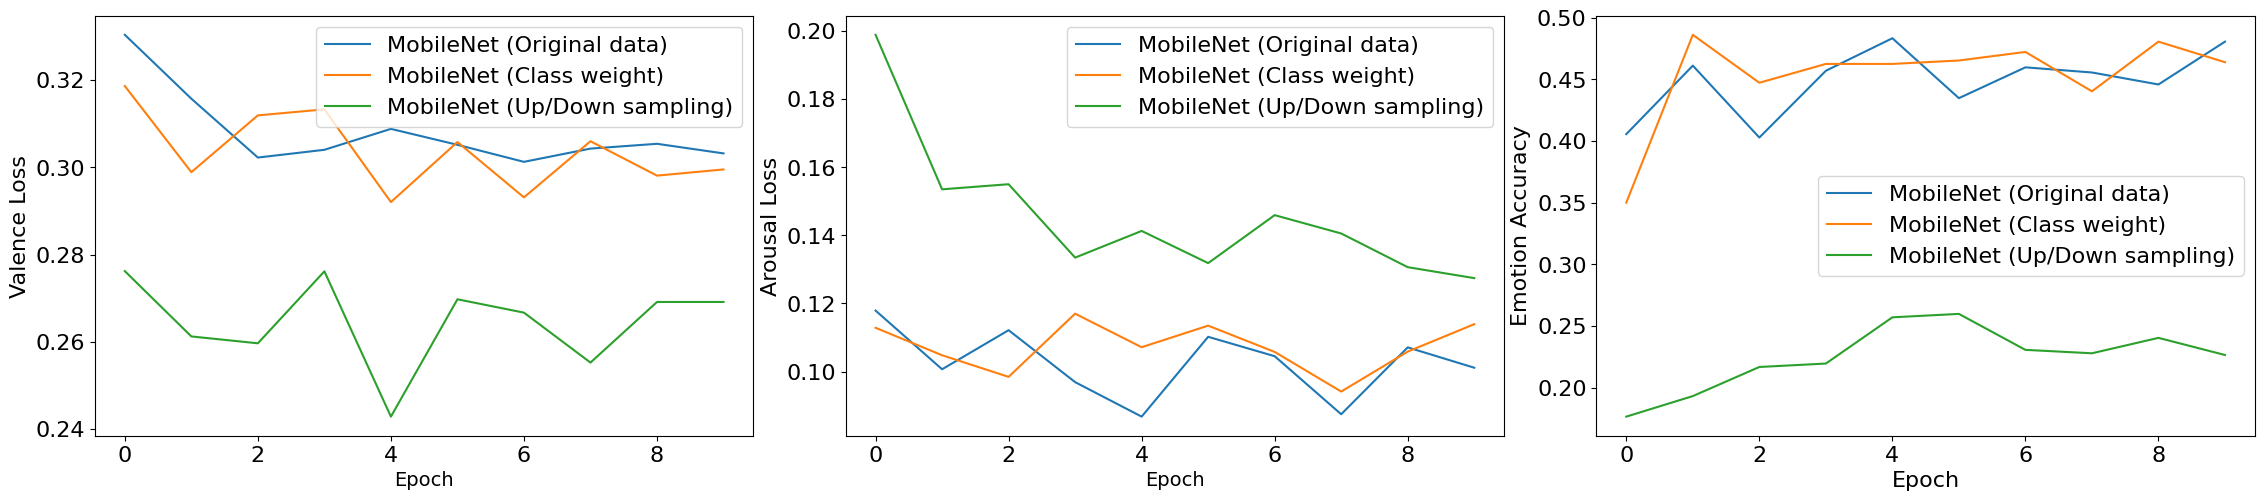

In [39]:
import pickle
import matplotlib.pyplot as plt

# Load the history objects from the files
with open('plots/MobileNethistoryOri.pkl', 'rb') as file:
    historyOri = pickle.load(file)
with open('plots/MobileNethistoryCW.pkl', 'rb') as file:
    historyCW = pickle.load(file)
with open('plots/MobileNethistoryUD.pkl', 'rb') as file:
    historyUD = pickle.load(file)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # 1 row, 3 columns

# Plot valence loss
axes[0].plot(historyOri['valence_loss'], label='MobileNet (Original data)')
axes[0].plot(historyCW['valence_loss'], label='MobileNet (Class weight)')
axes[0].plot(historyUD['valence_loss'], label='MobileNet (Up/Down sampling)')
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].set_ylabel('Valence Loss', fontsize=16)
axes[0].legend(fontsize=16, loc='upper right')
axes[0].tick_params(axis='both', labelsize=16)
# axes[0].set_title('Valence Loss During Training', fontsize=16)

# Plot arousal loss
axes[1].plot(historyOri['arousal_loss'], label='MobileNet (Original data)')
axes[1].plot(historyCW['arousal_loss'], label='MobileNet (Class weight)')
axes[1].plot(historyUD['arousal_loss'], label='MobileNet (Up/Down sampling)')
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Arousal Loss', fontsize=16)
axes[1].legend(fontsize=16)
axes[1].tick_params(axis='both', labelsize=16)
# axes[1].set_title('Arousal Loss During Training', fontsize=16)

# Plot emotion accuracy
axes[2].plot(historyOri['emotion_accuracy'], label='MobileNet (Original data)')
axes[2].plot(historyCW['emotion_accuracy'], label='MobileNet (Class weight)')
axes[2].plot(historyUD['emotion_accuracy'], label='MobileNet (Up/Down sampling)')
axes[2].set_xlabel('Epoch', fontsize=16)
axes[2].set_ylabel('Emotion Accuracy', fontsize=16)
axes[2].legend(fontsize=16)
axes[2].tick_params(axis='both', labelsize=16)
# axes[2].set_title('Emotion Accuracy During Training', fontsize=16)

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.14)

# Save the figure
plt.savefig("plots/MobileNet_metrics_horizontal.pdf", bbox_inches='tight')

# Show the plot
plt.show()


In [47]:
dfAlexOri = pd.read_csv("plots/csv_files_results/AlexNetOri_results.csv")
dfAlexCW = pd.read_csv("plots/csv_files_results/AlexNetCW_results.csv")
dfAlexUD = pd.read_csv("plots/csv_files_results/AlexNetUD_results.csv")

dfMobileOri = pd.read_csv("plots/csv_files_results/MobileNetOri_results.csv")
dfMobileCW = pd.read_csv("plots/csv_files_results/MobileNetCW_results.csv")
dfMobileUD = pd.read_csv("plots/csv_files_results/MobileNetUD_results.csv")

In [48]:
# Add a 'Model' column to each dataframe
dfAlexOri['Model'] = 'AlexNet (Original Data)'
dfAlexCW['Model'] = 'AlexNet (Class Weighting)'
dfAlexUD['Model'] = 'AlexNet (Up/Down Sampling)'

# Concatenate the dataframes
combined_df = pd.concat([dfAlexOri, dfAlexCW, dfAlexUD], ignore_index=True)

# Display the combined dataframe
print(combined_df)


       loss  valence_loss  arousal_loss  emotion_loss  valence_mae  \
0  3.461014      0.349380      0.217844      2.893789     0.512947   
1  6.520084      0.335505      0.207856      2.792832     0.498956   
2  2.615377      0.250547      0.150680      2.214151     0.412250   

   valence_accuracy  valence_ccc  valence_rmse  arousal_mae  arousal_accuracy  \
0          0.022222     1.000000      0.588372     0.403047          0.012500   
1          0.016667     1.000007      0.577181     0.392909          0.016667   
2          0.022222     0.999991      0.497260     0.328131          0.020833   

   arousal_ccc  arousal_rmse  emotion_accuracy                       Model  
0     1.000001      0.464879          0.129167     AlexNet (Original Data)  
1     1.000007      0.453492          0.129167   AlexNet (Class Weighting)  
2     0.999921      0.385747          0.116667  AlexNet (Up/Down Sampling)  


In [49]:
# Add a 'Model' column to each dataframe
dfMobileOri['Model'] = 'MobileNet (Original Data)'
dfMobileCW['Model'] = 'MobileNet (Class Weighting)'
dfMobileUD['Model'] = 'MobileNet (Up/Down Sampling)'

# Concatenate the dataframes
combined_df1 = pd.concat([dfMobileOri, dfMobileCW, dfMobileUD], ignore_index=True)

# Display the combined dataframe
print(combined_df1)


       loss  valence_loss  arousal_loss  emotion_loss  valence_mae  \
0  3.958572      0.263163      0.265004      3.430404     0.424214   
1  6.297535      0.248980      0.271441      2.699559     0.413768   
2  2.786844      0.255539      0.139743      2.391561     0.419420   

   valence_accuracy  valence_ccc  valence_rmse  arousal_mae  arousal_accuracy  \
0          0.018056          1.0      0.510779     0.430861          0.029167   
1          0.016667          1.0      0.496750     0.445348          0.015278   
2          0.020833          1.0      0.502150     0.317325          0.020833   

   arousal_ccc  arousal_rmse  emotion_accuracy                         Model  
0          1.0      0.512836          0.130556     MobileNet (Original Data)  
1          1.0      0.519342          0.125000   MobileNet (Class Weighting)  
2          1.0      0.371021          0.126389  MobileNet (Up/Down Sampling)  


In [2]:
import pandas as pd
dfAlexOri = pd.read_csv("plots/csv_files_results/PRF_emotion_AlexNetOri.csv")
dfAlexCW = pd.read_csv("plots/csv_files_results/PRF_emotion_AlexNetCW.csv")
dfAlexUD = pd.read_csv("plots/csv_files_results/PRF_emotion_AlexNetUD.csv")

dfMobileOri = pd.read_csv("plots/csv_files_results/PRF_emotion_MobileNetOri.csv")
dfMobileCW = pd.read_csv("plots/csv_files_results/PRF_emotion_MobileNetCW.csv")
dfMobileUD = pd.read_csv("plots/csv_files_results/PRF_emotion_MobileNetUD.csv")

In [4]:
# Add a 'Model' column to each dataframe
dfAlexOri['Model'] = 'AlexNet (Original Data)'
dfAlexCW['Model'] = 'AlexNet (Class Weighting)'
dfAlexUD['Model'] = 'AlexNet (Up/Down Sampling)'

# Concatenate the dataframes
combined_df = pd.concat([dfAlexOri, dfAlexCW, dfAlexUD], ignore_index=True)

# Display the combined dataframe
print(combined_df)


   Emotion precision  Emotion recall  Emotion F1-Score  \
0             0.1194             1.0            0.2134   
1             0.1542             1.0            0.2671   
2             0.0000             0.0            0.0000   

                        Model  
0     AlexNet (Original Data)  
1   AlexNet (Class Weighting)  
2  AlexNet (Up/Down Sampling)  


In [3]:
# Add a 'Model' column to each dataframe
dfMobileOri['Model'] = 'MobileNet (Original Data)'
dfMobileCW['Model'] = 'MobileNet (Class Weighting)'
dfMobileUD['Model'] = 'MobileNet (Up/Down Sampling)'

# Concatenate the dataframes
combined_df1 = pd.concat([dfMobileOri, dfMobileCW, dfMobileUD], ignore_index=True)

# Display the combined dataframe
print(combined_df1)


   Emotion precision  Emotion recall  Emotion F1-Score  \
0             0.1278             1.0            0.2266   
1             0.1278             1.0            0.2266   
2             0.1236             1.0            0.2200   

                          Model  
0     MobileNet (Original Data)  
1   MobileNet (Class Weighting)  
2  MobileNet (Up/Down Sampling)  


In [29]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# emotion_mapping = {
#     0: 'Neutral',
#     1: 'Happy',
#     2: 'Sad',
#     3: 'Surprise',
#     4: 'Fear',
#     5: 'Disgust',
#     6: 'Anger',
#     7: 'Contempt'
# }
# # Plot confusion matrix for emotion prediction with mapped labels
# emotion_labels_mapped = [emotion_mapping[i] for i in range(num_emotions)]
# cm_emotion_mapped = confusion_matrix(y_true_emotion, y_pred_emotion)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm_emotion_mapped, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels_mapped, yticklabels=emotion_labels_mapped)
# # plt.title('Emotion Prediction Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()